In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import operator

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
FOLDS = 4
N_JOBS = 6
SEED = 2016

#DATA = "Base"
#DATA = "Time"
#DATA = "Medians"
DATA = "Super"


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Get data
train = pd.read_csv("clean_data/train_" + DATA + ".csv")
y = pd.read_csv("clean_data/y.csv")

X_train = pd.read_csv("clean_data/X_train_" + DATA + ".csv")
y_train = pd.read_csv("clean_data/y_train.csv")

X_trainVal = pd.read_csv("clean_data/X_trainVal_" + DATA + ".csv")
y_trainVal = pd.read_csv("clean_data/y_trainVal.csv")

test = pd.read_csv("clean_data/test_" + DATA + ".csv")

X_test = pd.read_csv("clean_data/X_test_" + DATA + ".csv")
y_test = pd.read_csv("clean_data/y_test.csv")

X_testVal = pd.read_csv("clean_data/X_testVal_" + DATA + ".csv")
y_testVal = pd.read_csv("clean_data/y_testVal.csv")


In [3]:
# Definitions for XGBoost

xg_params = {
    "booster" : "gbtree", 
    "eta" : 0.01,
    "max_depth" : 7,
    "min_child_weight" : 11,
    "subsample" : 0.99,
    "colsample_bytree" : 0.98,
    "colsample_bylevel" : 0.80,
    "gamma" : 0.05,
    "base_score" : 0.15,
    "objective" : "reg:linear",
}

def xgb_mse(preds, dtrain) :
    labels = dtrain.get_label()
    return ("mse", mean_squared_error(preds, labels))

def run_xgb(X_trainVal, y_trainVal, X_testVal, y_testVal, X_train, y_train) :
    xg_trainVal = xgb.DMatrix(X_trainVal, label = y_trainVal)
    xg_testVal = xgb.DMatrix(X_testVal, label = y_testVal)
    xg_train = xgb.DMatrix(X_train, label = y_train)
    
    watchlist = [(xg_trainVal, "train"), (xg_testVal, "eval")]    
    
    # Train model
    xg = xgb.train(
        params = xg_params,
        dtrain = xg_trainVal,
        evals = watchlist, 
        num_boost_round = 100000,
        early_stopping_rounds = 100,
        feval = xgb_mse, 
        maximize = False,
        verbose_eval = 250)
    
    print("XGBOOST best_iteration " + str(xg.best_iteration))
    print("XGBOOST best_score " + str(xg.best_score))
    
    xg = xgb.train(
        params = xg_params, 
        dtrain = xg_train, 
        num_boost_round = int(xg.best_ntree_limit / 0.67),
        feval = xgb_mse, 
        maximize = False,
        verbose_eval = 250)

    return (xg_testVal, xg)

In [4]:
# Generate y_test predictions to be able to optimize ensemble weights
xg_test = xgb.DMatrix(X_test)

xg_val, xg = run_xgb(X_trainVal, y_trainVal.TARGET, X_testVal, y_testVal.TARGET, X_train, y_train.TARGET)
preds_y_test = xg.predict(xg_test) 

[0]	train-mse:778.267	eval-mse:651.764
Multiple eval metrics have been passed: 'eval-mse' will be used for early stopping.

Will train until eval-mse hasn't improved in 100 rounds.
[250]	train-mse:129.201	eval-mse:184.272
[500]	train-mse:99.9629	eval-mse:180.025
[750]	train-mse:89.3963	eval-mse:177.886
[1000]	train-mse:82.6586	eval-mse:176.51
[1250]	train-mse:77.4496	eval-mse:174.627
[1500]	train-mse:73.5631	eval-mse:173.582
[1750]	train-mse:70.3797	eval-mse:173.021
[2000]	train-mse:67.8328	eval-mse:172.524
[2250]	train-mse:65.6759	eval-mse:172.014
[2500]	train-mse:63.6205	eval-mse:171.558
[2750]	train-mse:61.8044	eval-mse:171.016
[3000]	train-mse:60.3032	eval-mse:170.685
[3250]	train-mse:58.8217	eval-mse:170.416
[3500]	train-mse:57.4725	eval-mse:170.2
[3750]	train-mse:56.2154	eval-mse:169.969
[4000]	train-mse:55.0308	eval-mse:169.583
[4250]	train-mse:53.8555	eval-mse:169.397
[4500]	train-mse:52.7622	eval-mse:169.135
[4750]	train-mse:51.7706	eval-mse:168.981
[5000]	train-mse:50.7742	ev

In [5]:
# Show MSE on y_test
print("Average XGB MSE on held-out fold : " + str(mean_squared_error(y_test.TARGET, preds_y_test)))


Average XGB MSE on held-out fold : 96.6331186896


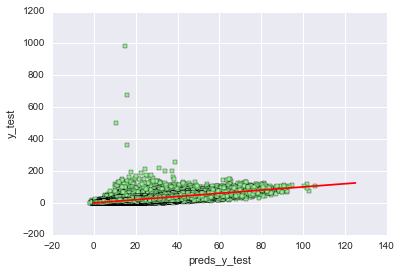

()

In [6]:
# Plot predictions
def plotPreds(preds, reals, xlbl, ylbl, dim) :
    plt.scatter(preds, reals, c = "lightgreen", marker = "s", label = "")
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.plot([0, dim], [0, dim], c = "red")
    plt.show()
    return()

plotPreds(preds_y_test, y_test.TARGET, "preds_y_test", "y_test", 125)


In [7]:
# Save held-out fold predictions
y_test_name = "y_test_preds/XGB_" + DATA + ".csv"
pd.DataFrame({"TARGET": preds_y_test}).to_csv(y_test_name, index = None, sep = ";")


In [8]:
# Now generate predictions on whole test set, to be used in ensemble for submissions
print("DATA : " + DATA)
xg_test = xgb.DMatrix(test.drop(["ID"], axis = 1))

xg_val, xg = run_xgb(X_train, y_train.TARGET, X_test, y_test.TARGET, train, y.TARGET)
preds_test = xg.predict(xg_test) 


DATA : Super
[0]	train-mse:718.068	eval-mse:575.109
Multiple eval metrics have been passed: 'eval-mse' will be used for early stopping.

Will train until eval-mse hasn't improved in 100 rounds.
[250]	train-mse:127.151	eval-mse:139.798
[500]	train-mse:98.2009	eval-mse:127.837
[750]	train-mse:87.4081	eval-mse:121.378
[1000]	train-mse:80.735	eval-mse:117.294
[1250]	train-mse:75.8504	eval-mse:114.602
[1500]	train-mse:72.3805	eval-mse:112.527
[1750]	train-mse:69.796	eval-mse:111.102
[2000]	train-mse:67.3989	eval-mse:109.76
[2250]	train-mse:65.1953	eval-mse:108.515
[2500]	train-mse:63.3863	eval-mse:107.488
[2750]	train-mse:61.7543	eval-mse:106.537
[3000]	train-mse:60.2315	eval-mse:105.765
[3250]	train-mse:58.848	eval-mse:105.066
[3500]	train-mse:57.4392	eval-mse:104.301
[3750]	train-mse:56.3007	eval-mse:103.726
[4000]	train-mse:55.2009	eval-mse:103.173
[4250]	train-mse:54.1444	eval-mse:102.634
[4500]	train-mse:53.1468	eval-mse:102.129
[4750]	train-mse:52.2284	eval-mse:101.692
[5000]	train-ms

In [9]:
# Correct predictions for negative outputs
preds_test[preds_test < 0] = 0

In [10]:
# Save test set predictions
testID = pd.read_csv("clean_data/testID.csv", header = None)
test_name = "test_preds/XGB_" + DATA + ".csv"
pd.DataFrame({"ID": testID[0], "TARGET": preds_test}, columns = ["ID", "TARGET"]).to_csv(test_name, index = None, sep = ";")

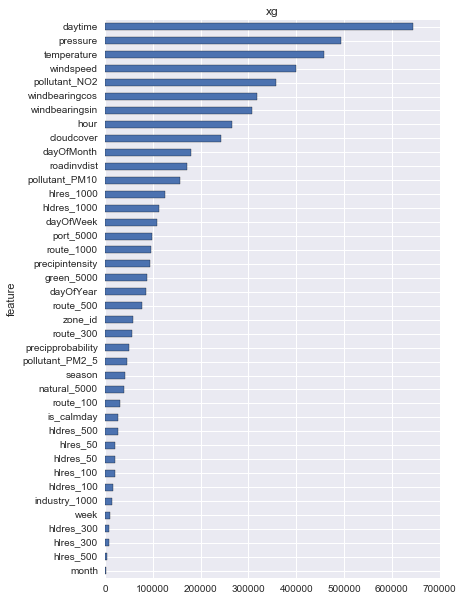

In [11]:
# Visualize most important features
importance = sorted(xg.get_fscore().items(), key = operator.itemgetter(1))
df = pd.DataFrame(importance, columns=["feature", "fscore"])
g = df.tail(50).plot(kind = "barh", x = "feature", y = "fscore", legend = False, figsize = (6, 10))
plt.title("xg")
plt.show()